<h1>Gap-filling using random forest (2005, 2008, 2009, 2016)</h1>
- for these four years the MDS gap-filling produced unrealistic results due to long data gaps

# Imports

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
from diive.core.io.files import save_parquet, load_parquet
from diive.pkgs.gapfilling.randomforest_ts import RandomForestTS
from diive.core.plotting.heatmap_datetime import HeatmapDateTime

# Settings

In [2]:
SWIN_COL = "SW_IN_T1_2_1"
TA_COL = "TA_T1_2_1"
VPD_COL = "VPD_T1_2_1"
MGMT_VARS = [
    'TIMESINCE_MGMT_FERT_MIN_FOOTPRINT', 'TIMESINCE_MGMT_FERT_ORG_FOOTPRINT', 'TIMESINCE_MGMT_GRAZING_FOOTPRINT',
    'TIMESINCE_MGMT_MOWING_FOOTPRINT', 'TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT', 'TIMESINCE_MGMT_SOWING_FOOTPRINT',
    'TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT']

# Random forest model settings
rf_settings = dict(
    verbose=1,    
    features_lag=[-1, -1], 
    features_lag_exclude_cols=MGMT_VARS,  # Management variables are not lagged
    include_timestamp_as_features=True,    
    add_continuous_record_number=True,
    sanitize_timestamp=True,
    n_estimators=200,
    random_state=42,
    min_samples_split=2,
    min_samples_leaf=1,
    perm_n_repeats=10,
    n_jobs=-1)

# Load main data

In [3]:
SOURCEDIR = r"../32_FLUXES_L1_FluxProcessingChain_IRGA"
FILENAME = r"32.8_FluxProcessingChain_L3.3_NEE_LE_H.parquet"
FILEPATH = Path(SOURCEDIR) / FILENAME
maindf = load_parquet(filepath=FILEPATH)

Loaded .parquet file ..\32_FLUXES_L1_FluxProcessingChain_IRGA\32.8_FluxProcessingChain_L3.3_NEE_LE_H.parquet (0.530 seconds). Detected time resolution of <30 * Minutes> / 30min 


In [4]:
maindf

AIR_MV  AIR_DENSITY  AIR_RHO_CP   AIR_CP  AOA_METHOD  AXES_ROTATION_METHOD  ...  SUM_L3.3_CUT_NONE_H_L3.1_HARDFLAGS  SUM_L3.3_CUT_NONE_H_L3.1_SOFTFLAGS  SUM_L3.3_CUT_NONE_H_L3.1_FLAGS  FLAG_L3.3_CUT_NONE_H_L3.1_QCF  H_L3.1_L3.3_CUT_NONE_QCF  H_L3.1_L3.3_CUT_NONE_QCF0
TIMESTAMP_MIDDLE                                                                                   ...                                                                                                                                                                                            
2005-01-01 00:15:00       NaN          NaN         NaN      NaN         NaN                   NaN  ...                                 2.0                                 0.0                             2.0                            2.0                       NaN                        NaN
2005-01-01 00:45:00       NaN          NaN         NaN      NaN         NaN                   NaN  ...                                 2.0                                 0.0                             2.0                            2.0                       NaN                        NaN
2005-01-01 01:15:00       NaN          NaN         NaN      NaN         NaN                   NaN  ...                                 2.0                                 0.0                             2.0                            2.0                       NaN                        NaN
2005-01-01 01:45:00       NaN          NaN         NaN      NaN         NaN                   NaN  ...                                 2.0                                 0.0                             2.0                            2.0                       NaN                        NaN
2005-01-01 02:15:00       NaN          NaN         NaN      NaN         NaN                   NaN  ...                                 2.0                                 0.0                             2.0                            2.0                       NaN                        NaN
...                       ...          ...         ...      ...         ...                   ...  ...                                 ...                                 ...                             ...                            ...                       ...                        ...
2023-12-31 22:45:00  0.023718      1.21785     1228.93  1009.10         0.0                   1.0  ...                                 0.0                                 0.0                             0.0                            0.0                -29.190743                 -29.190743
2023-12-31 23:15:00  0.023710      1.21827     1229.34  1009.09         0.0                   1.0  ...                                 0.0                                 0.0                             0.0                            0.0                -31.241158                 -31.241158
2023-12-31 23:45:00  0.023715      1.21807     1229.13  1009.08         0.0                   1.0  ...                                 0.0                                 0.0                             0.0                            0.0                -38.598898                 -38.598898
2024-01-01 00:15:00  0.023648      1.22454     1233.24  1007.10         0.0                   1.0  ...                                 0.0                                 0.0                             0.0                            0.0                -24.008740                 -24.008740
2024-01-01 00:45:00  0.023590      1.22761     1236.02  1006.85         0.0                   1.0  ...                                 0.0                                 0.0                             0.0                            0.0                -17.766680                 -17.766680

[333074 rows x 498 columns]

In [5]:
print("MANAGEMENT-IN-FOOTPRINT VARIABLES:")
[print(f"  {c}") for c in maindf if "FOOTPRINT" in c];

MANAGEMENT-IN-FOOTPRINT VARIABLES:
  FOOTPRINT_MODEL
  MGMT_FERT_MIN_FOOTPRINT
  MGMT_FERT_ORG_FOOTPRINT
  MGMT_GRAZING_FOOTPRINT
  MGMT_MOWING_FOOTPRINT
  MGMT_PESTICIDE_HERBICIDE_FOOTPRINT
  MGMT_SOILCULTIVATION_FOOTPRINT
  MGMT_SOWING_FOOTPRINT
  TIMESINCE_MGMT_FERT_MIN_FOOTPRINT
  TIMESINCE_MGMT_FERT_ORG_FOOTPRINT
  TIMESINCE_MGMT_GRAZING_FOOTPRINT
  TIMESINCE_MGMT_MOWING_FOOTPRINT
  TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT
  TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT
  TIMESINCE_MGMT_SOWING_FOOTPRINT


# Gap-filling

## Set data range for models

In [6]:
# Set data range for models
locs_2005 = (maindf.index.year >= 2005) & (maindf.index.year <= 2007)  # Source data for gap-filling 2005: 2005-2007
locs_2008_2009 = (maindf.index.year >= 2007) & (maindf.index.year <= 2010)  # Source data for gap-filling 2008 and 2009: 2007-2010
locs_2016 = (maindf.index.year >= 2015) & (maindf.index.year <= 2017)  # Source data for gap-filling 2005: 2015-2017

## Function for random forest execution

In [7]:
def run(target_col: str, locs, years: list):
    
    # Make subset of required data    
    USECOLS = [target_col, SWIN_COL, TA_COL, VPD_COL]
    USECOLS = USECOLS + MGMT_VARS
    subset = maindf[locs].copy()
    subset = subset[USECOLS].copy()
    
    # Run random forest
    rfts = RandomForestTS(
        input_df=subset,
        target_col=target_col,
        **rf_settings)
    
    rfts.reduce_features()
    # rfts.report_feature_reduction()
    rfts.trainmodel(showplot_scores=False, showplot_importance=False)
    # rfts.report_traintest()
    rfts.fillgaps(showplot_scores=False, showplot_importance=False)
    rfts.report_gapfilling()

    # Results
    res = rfts.gapfilling_df_
    
    # Results for relevant year(s)
    fluxname_filled = rfts.get_gapfilled_target().name
    flagname_filled = rfts.get_flag().name
    res_year = res[(res.index.year >= years[0]) & (res.index.year <= years[1])].copy()
    res_year = res_year[[fluxname_filled, flagname_filled]].copy()   

    # Heatmaps
    fig = plt.figure(facecolor='white', figsize=(10, 12), dpi=72)
    gs = gridspec.GridSpec(1, 2)  # rows, cols
    gs.update(wspace=0.6, hspace=0.1, left=0.03, right=0.97, top=0.95, bottom=0.05)
    ax1 = ax_series = fig.add_subplot(gs[0, 0])
    ax2 = ax_series = fig.add_subplot(gs[0, 1])
    HeatmapDateTime(series=res[target_col], ax=ax1).plot()
    HeatmapDateTime(series=res[fluxname_filled], ax=ax2).plot()  

    return res_year, rfts  # Returns results and instance

## Dataframe to collect results across years

In [8]:
collection_df = pd.DataFrame()
collection_instances_dict = {}

## NEE



Starting gap-filling for
NEE_L3.1_L3.3_CUT_50_QCF
using <class 'sklearn.ensemble._forest.RandomForestRegressor'>

Adding new data columns ...
++ Added new columns with lagged variants for: ['SW_IN_T1_2_1', 'TA_T1_2_1', 'VPD_T1_2_1'] (lags between -1 and -1 with stepsize 1), no lagged variants for: ['NEE_L3.1_L3.3_CUT_50_QCF', 'TIMESINCE_MGMT_FERT_MIN_FOOTPRINT', 'TIMESINCE_MGMT_FERT_ORG_FOOTPRINT', 'TIMESINCE_MGMT_GRAZING_FOOTPRINT', 'TIMESINCE_MGMT_MOWING_FOOTPRINT', 'TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT', 'TIMESINCE_MGMT_SOWING_FOOTPRINT', 'TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT']. Shifting the time series created gaps which were then filled with the nearest value.
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 52560.

Sanitizing timestamp ...
>>> Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Tim

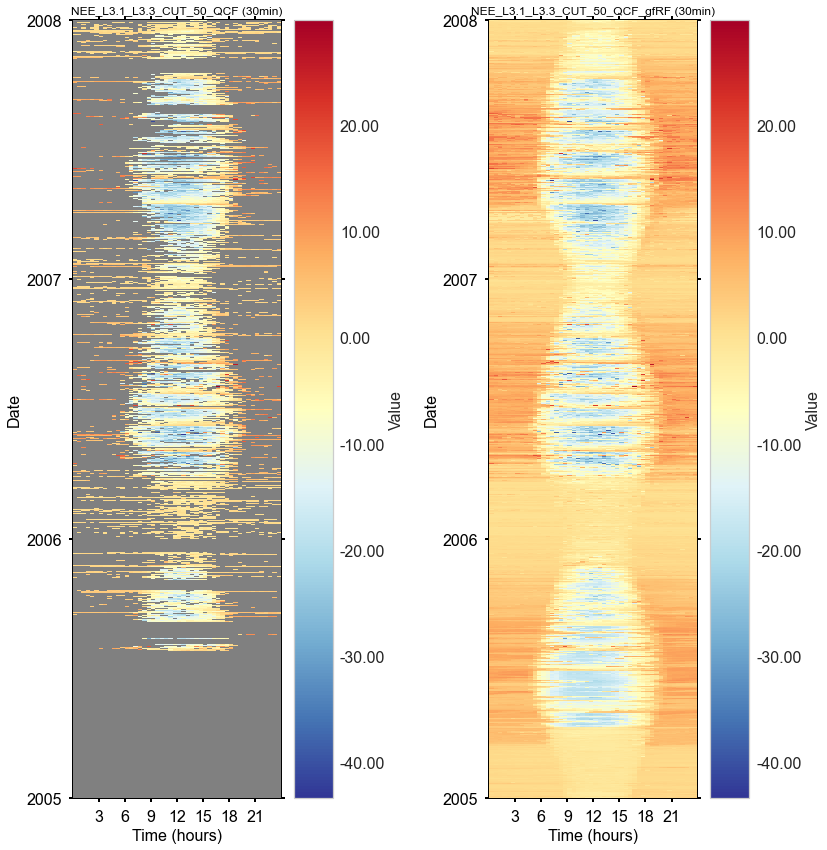

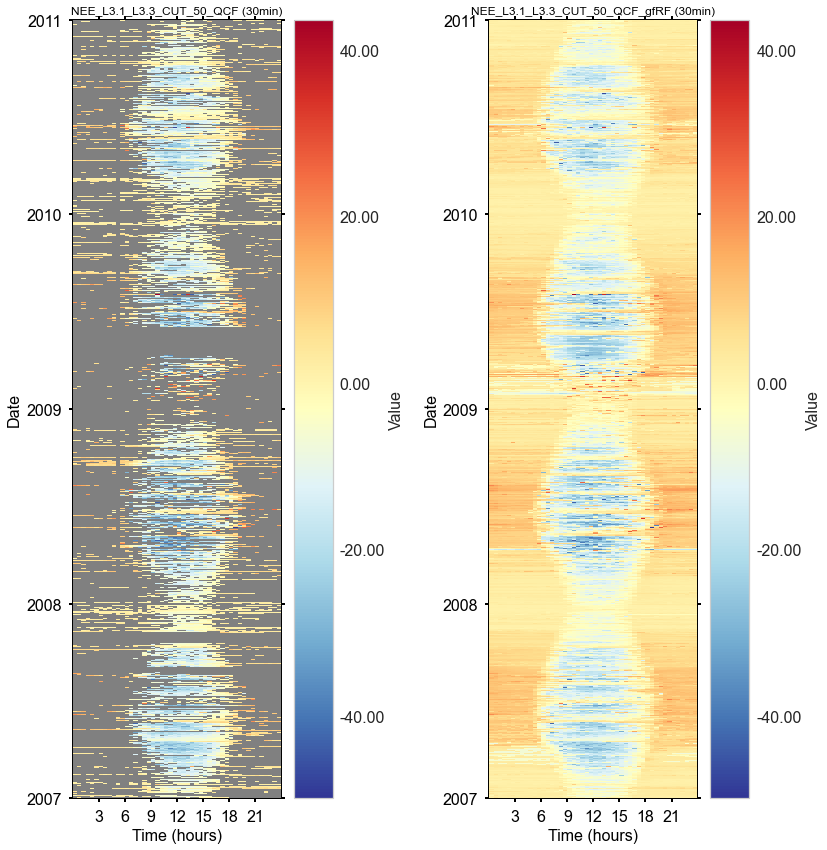

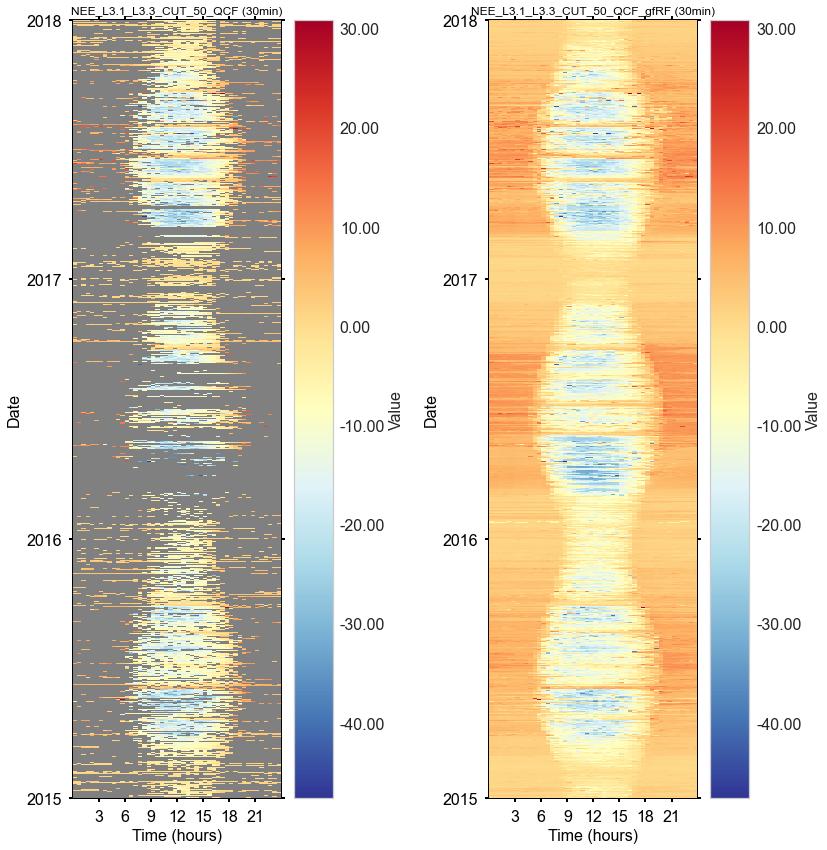

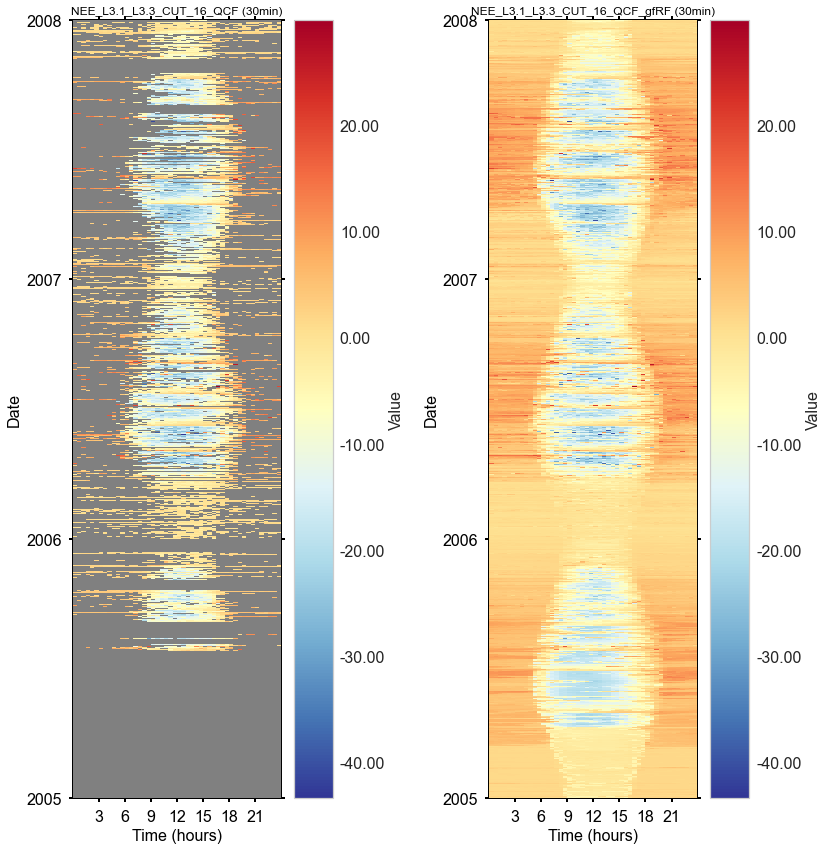

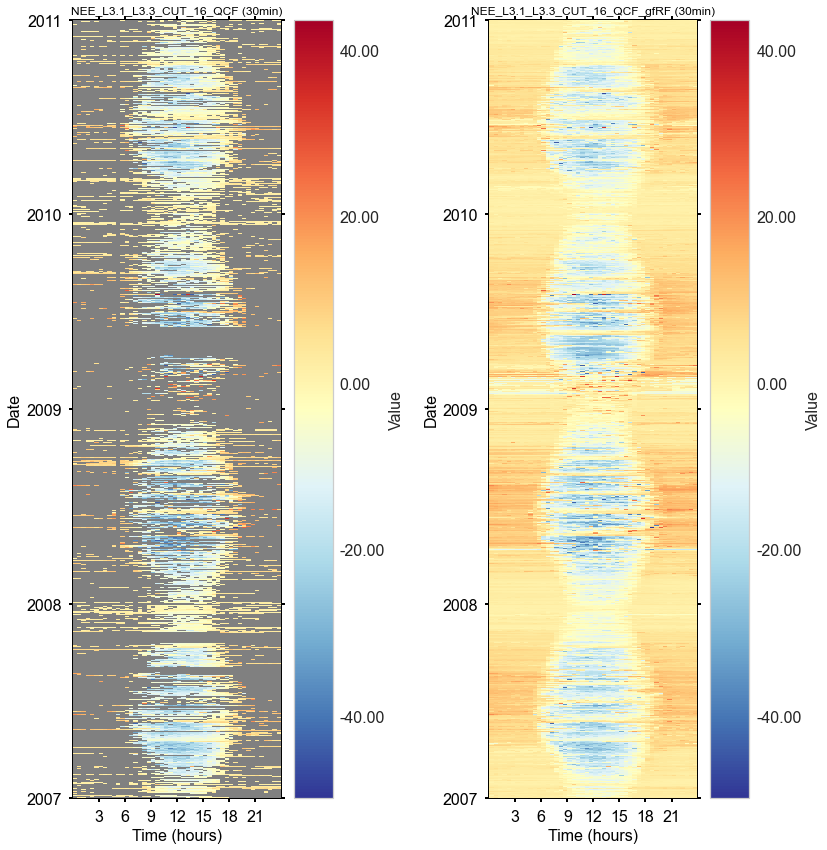

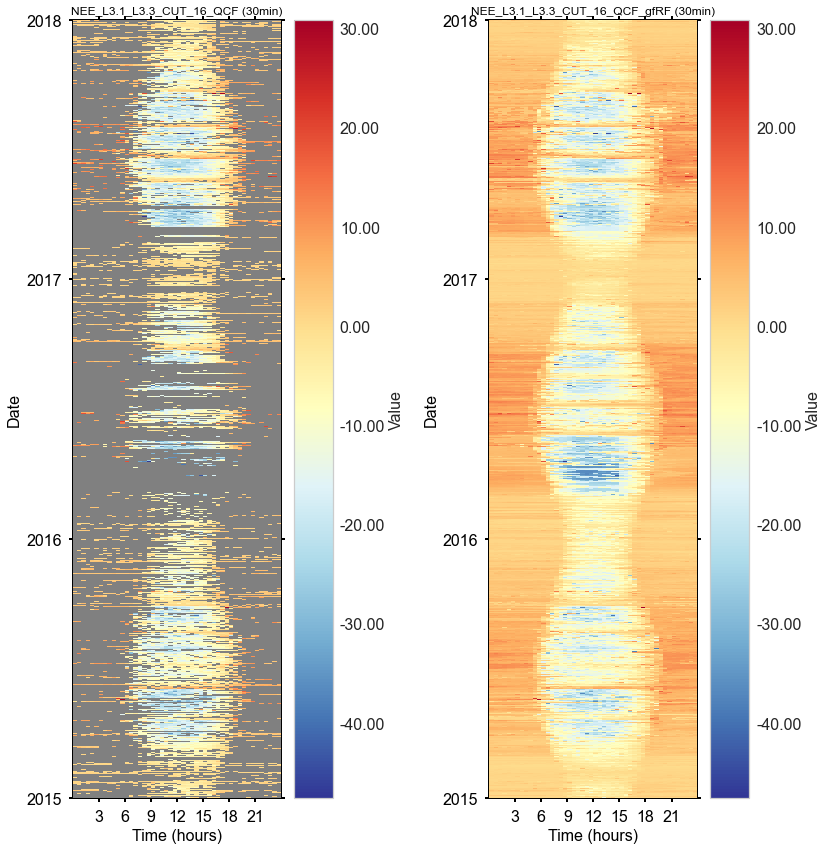

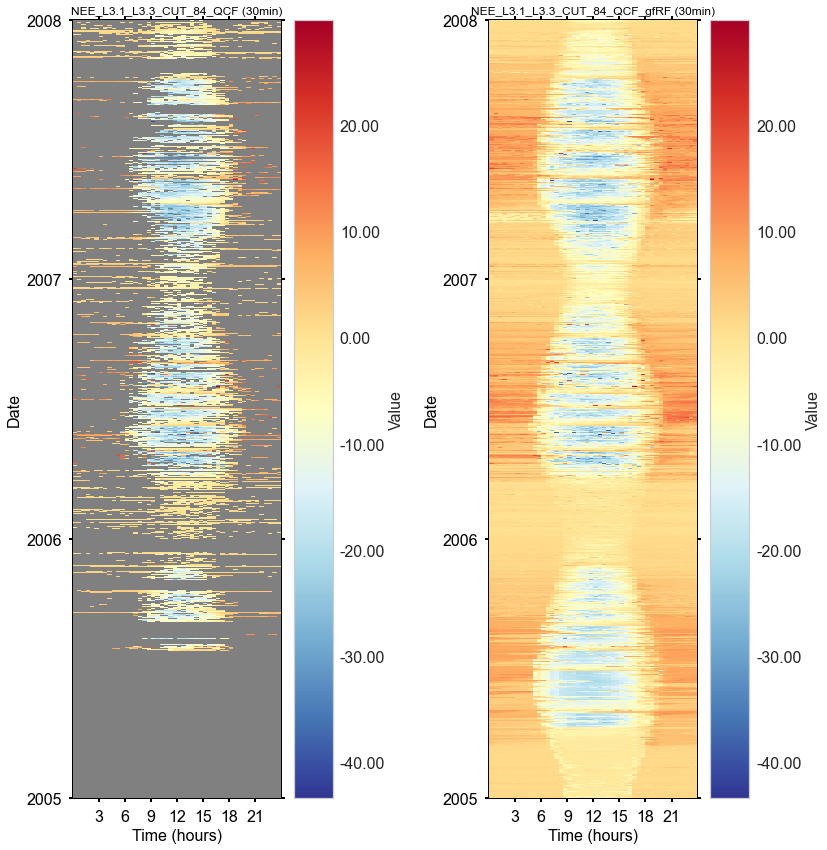

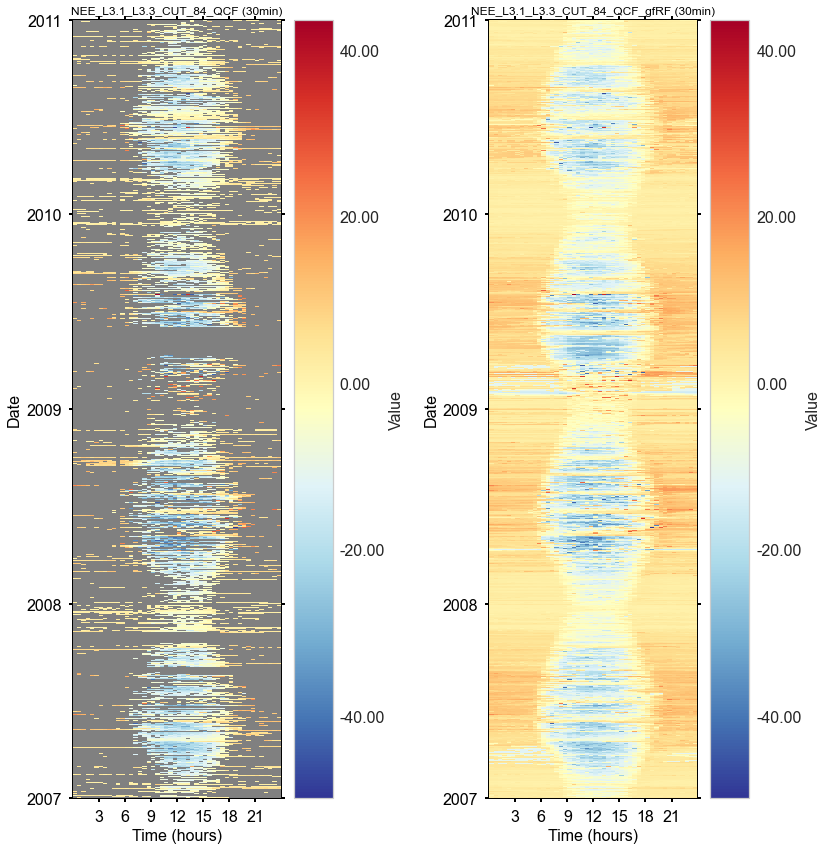

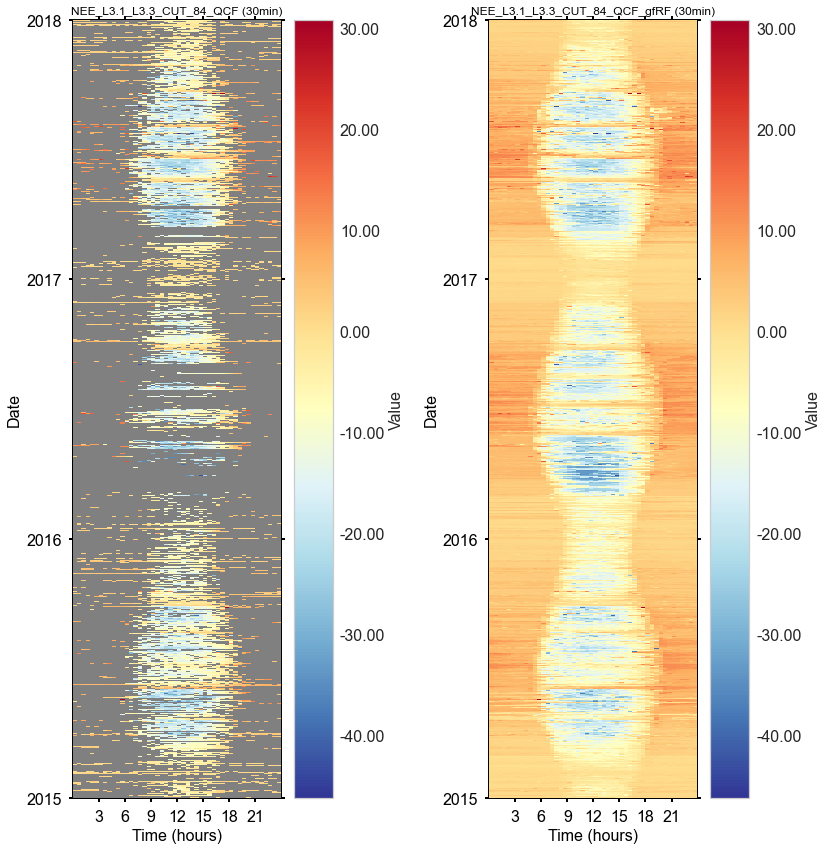

In [9]:
target_cols = ["NEE_L3.1_L3.3_CUT_50_QCF", "NEE_L3.1_L3.3_CUT_16_QCF", "NEE_L3.1_L3.3_CUT_84_QCF"]
# target_cols = ["NEE_L3.1_L3.3_CUT_50_QCF"]

for target_col in target_cols:
    res_2005, instance_2005 = run(target_col=target_col, locs=locs_2005, years=[2005, 2005])
    res_2008_2009, instance_2008_2009 = run(target_col=target_col, locs=locs_2008_2009, years=[2008, 2009])
    res_2016, instance_2016 = run(target_col=target_col, locs=locs_2016, years=[2016, 2016])

    # Merge results along timestamp index
    res_merged = pd.concat([res_2005, res_2008_2009, res_2016], axis=0)
    
    # Add results (gap-filled variable and flag) to collection of results
    collection_df = pd.concat([collection_df, res_merged], axis=1)  # Add to collection of results, add to existing column
    
    # # Add random forest instance to collection of instances
    # collection_instances_dict[str(years[0])] = rfts

## LE



Starting gap-filling for
LE_L3.1_L3.3_CUT_NONE_QCF
using <class 'sklearn.ensemble._forest.RandomForestRegressor'>

Adding new data columns ...
++ Added new columns with lagged variants for: ['SW_IN_T1_2_1', 'TA_T1_2_1', 'VPD_T1_2_1'] (lags between -1 and -1 with stepsize 1), no lagged variants for: ['LE_L3.1_L3.3_CUT_NONE_QCF', 'TIMESINCE_MGMT_FERT_MIN_FOOTPRINT', 'TIMESINCE_MGMT_FERT_ORG_FOOTPRINT', 'TIMESINCE_MGMT_GRAZING_FOOTPRINT', 'TIMESINCE_MGMT_MOWING_FOOTPRINT', 'TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT', 'TIMESINCE_MGMT_SOWING_FOOTPRINT', 'TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT']. Shifting the time series created gaps which were then filled with the nearest value.
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 52560.

Sanitizing timestamp ...
>>> Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... T

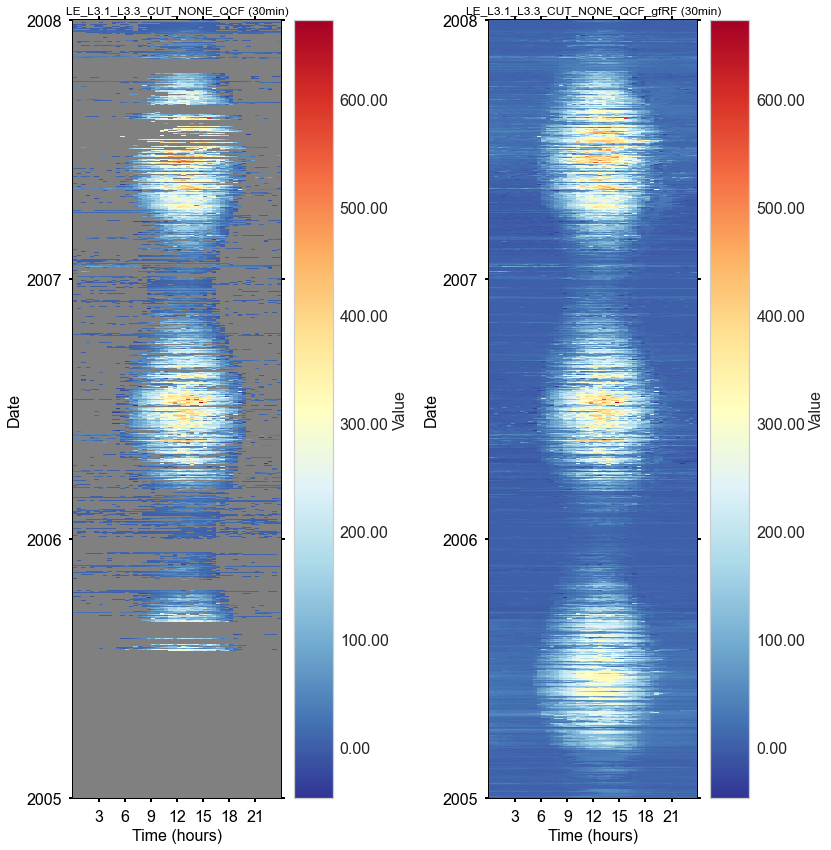

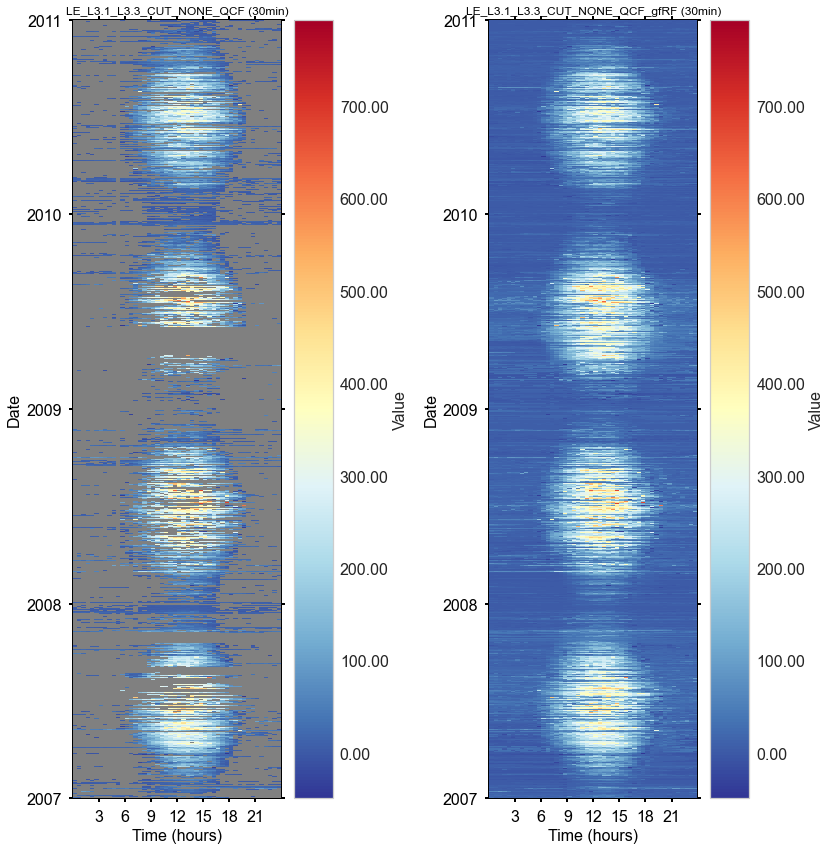

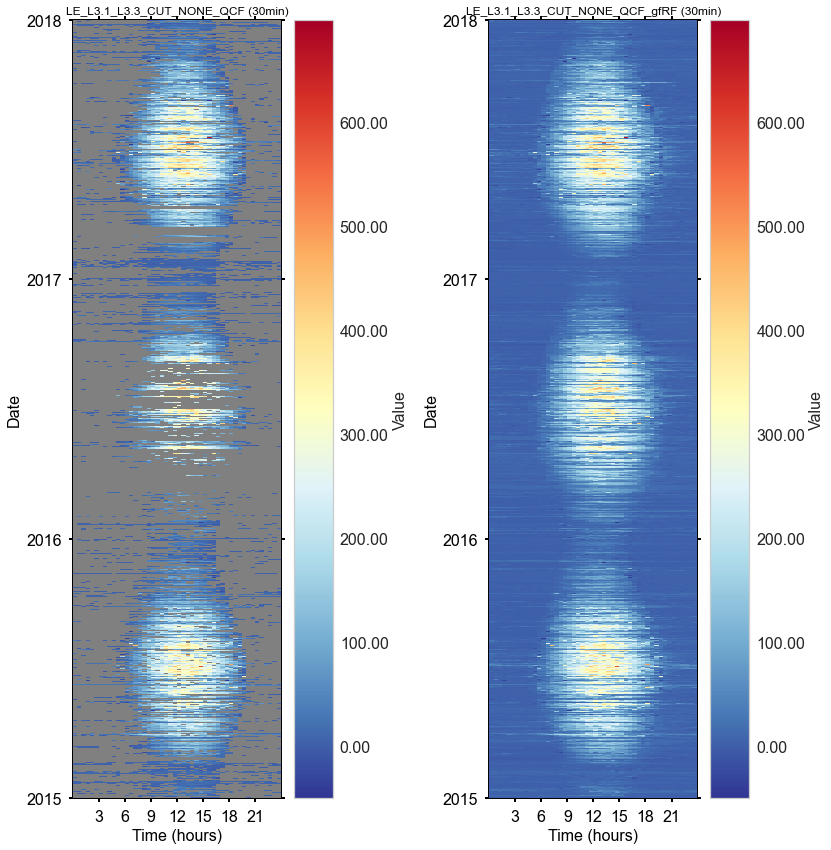

In [10]:
target_cols = ["LE_L3.1_L3.3_CUT_NONE_QCF"]

for target_col in target_cols:
    res_2005, instance_2005 = run(target_col=target_col, locs=locs_2005, years=[2005, 2005])
    res_2008_2009, instance_2008_2009 = run(target_col=target_col, locs=locs_2008_2009, years=[2008, 2009])
    res_2016, instance_2016 = run(target_col=target_col, locs=locs_2016, years=[2016, 2016])

    # Merge results along timestamp index
    res_merged = pd.concat([res_2005, res_2008_2009, res_2016], axis=0)
    
    # Add results (gap-filled variable and flag) to collection of results
    collection_df = pd.concat([collection_df, res_merged], axis=1)  # Add to collection of results, add to existing column
    
    # # Add random forest instance to collection of instances
    # collection_instances_dict[str(years[0])] = rfts

## H



Starting gap-filling for
H_L3.1_L3.3_CUT_NONE_QCF
using <class 'sklearn.ensemble._forest.RandomForestRegressor'>

Adding new data columns ...
++ Added new columns with lagged variants for: ['SW_IN_T1_2_1', 'TA_T1_2_1', 'VPD_T1_2_1'] (lags between -1 and -1 with stepsize 1), no lagged variants for: ['H_L3.1_L3.3_CUT_NONE_QCF', 'TIMESINCE_MGMT_FERT_MIN_FOOTPRINT', 'TIMESINCE_MGMT_FERT_ORG_FOOTPRINT', 'TIMESINCE_MGMT_GRAZING_FOOTPRINT', 'TIMESINCE_MGMT_MOWING_FOOTPRINT', 'TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT', 'TIMESINCE_MGMT_SOWING_FOOTPRINT', 'TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT']. Shifting the time series created gaps which were then filled with the nearest value.
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 52560.

Sanitizing timestamp ...
>>> Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Tim

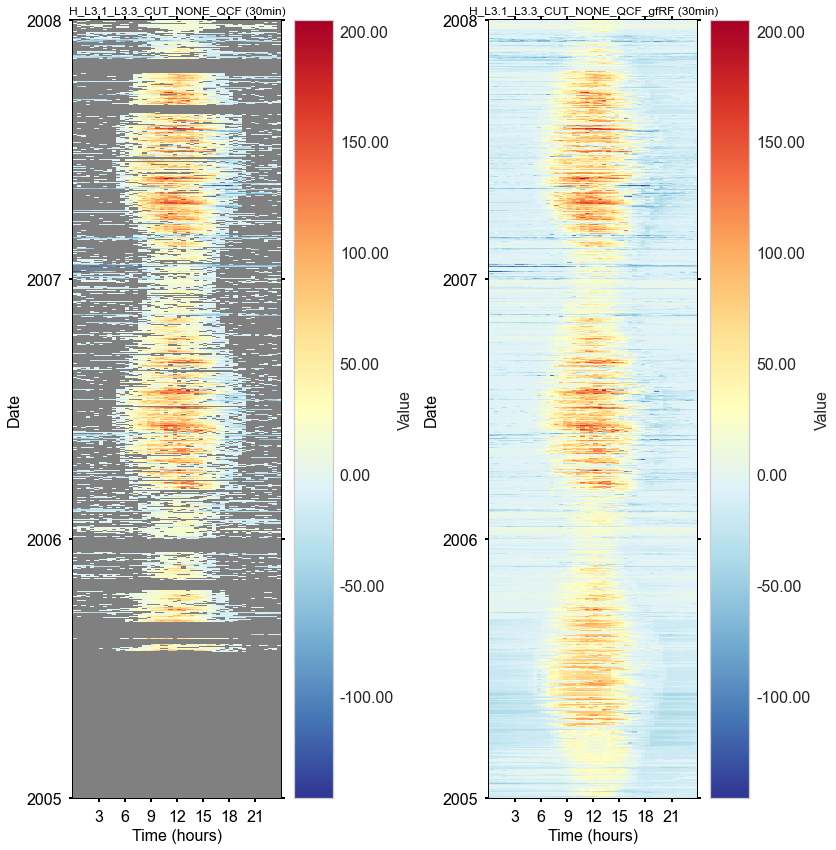

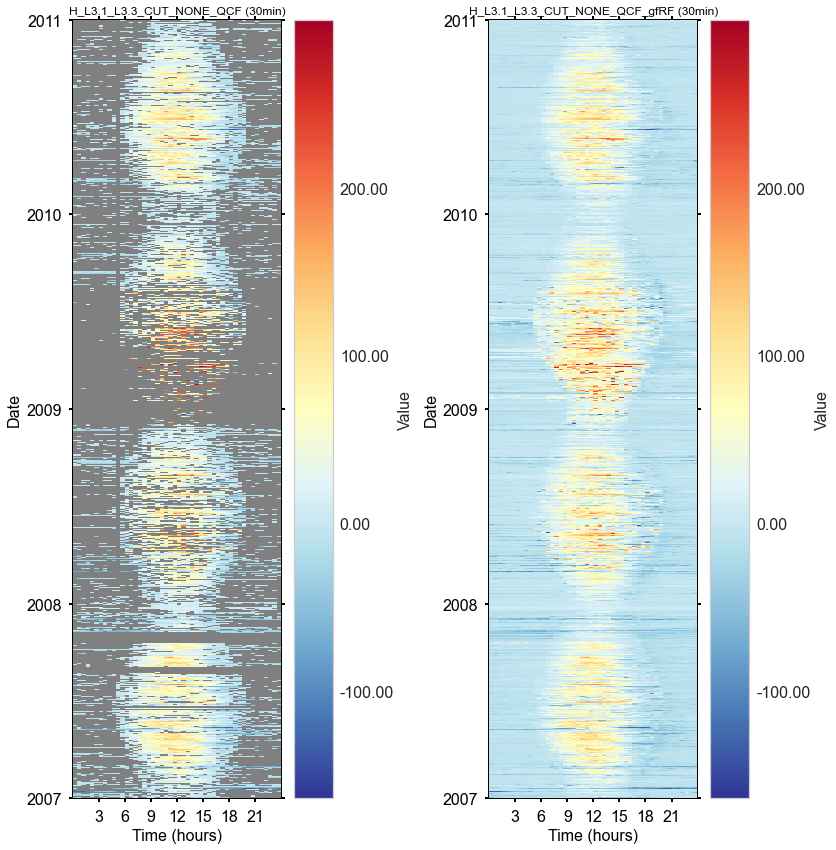

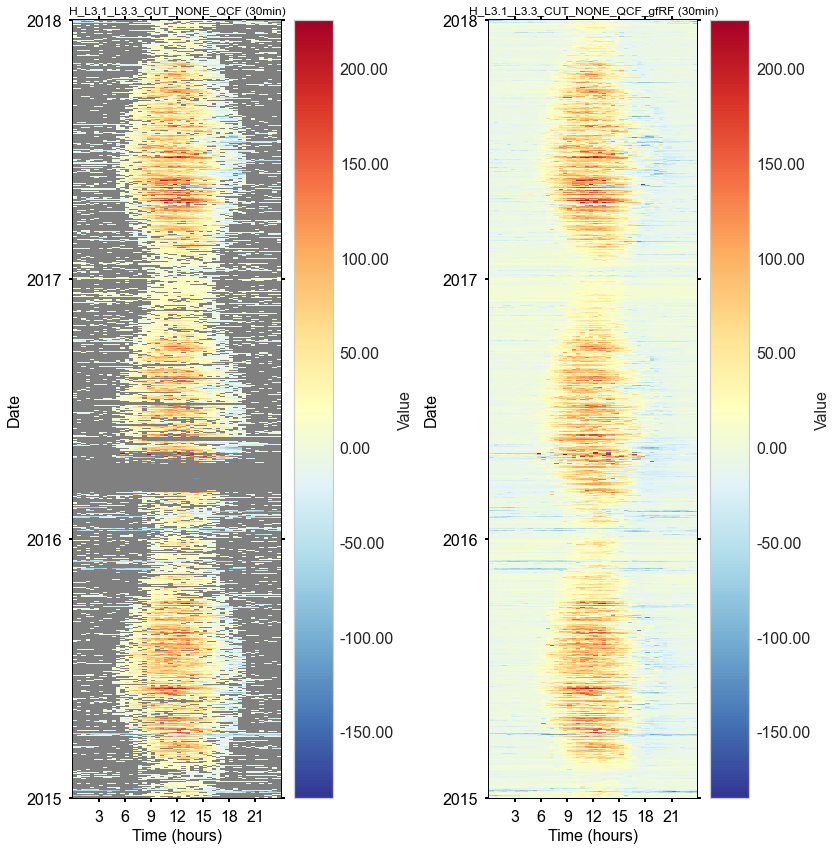

In [11]:
target_cols = ["H_L3.1_L3.3_CUT_NONE_QCF"]

for target_col in target_cols:
    res_2005, instance_2005 = run(target_col=target_col, locs=locs_2005, years=[2005, 2005])
    res_2008_2009, instance_2008_2009 = run(target_col=target_col, locs=locs_2008_2009, years=[2008, 2009])
    res_2016, instance_2016 = run(target_col=target_col, locs=locs_2016, years=[2016, 2016])

    # Merge results along timestamp index
    res_merged = pd.concat([res_2005, res_2008_2009, res_2016], axis=0)
    
    # Add results (gap-filled variable and flag) to collection of results
    collection_df = pd.concat([collection_df, res_merged], axis=1)  # Add to collection of results, add to existing column
    
    # # Add random forest instance to collection of instances
    # collection_instances_dict[str(years[0])] = rfts

# COLLECTION

In [12]:
# Check for duplicates in timestamp index and column names
print(collection_df.index.duplicated().sum())
print(collection_df.columns.duplicated().sum())

0
0


In [13]:
collection_df

NEE_L3.1_L3.3_CUT_50_QCF_gfRF  FLAG_NEE_L3.1_L3.3_CUT_50_QCF_gfRF_ISFILLED  NEE_L3.1_L3.3_CUT_16_QCF_gfRF  FLAG_NEE_L3.1_L3.3_CUT_16_QCF_gfRF_ISFILLED  NEE_L3.1_L3.3_CUT_84_QCF_gfRF  FLAG_NEE_L3.1_L3.3_CUT_84_QCF_gfRF_ISFILLED  LE_L3.1_L3.3_CUT_NONE_QCF_gfRF  FLAG_LE_L3.1_L3.3_CUT_NONE_QCF_gfRF_ISFILLED  H_L3.1_L3.3_CUT_NONE_QCF_gfRF  FLAG_H_L3.1_L3.3_CUT_NONE_QCF_gfRF_ISFILLED
TIMESTAMP_MIDDLE                                                                                                                                                                                                                                                                                                                                                                                                 
2005-01-01 00:15:00                       1.700941                                            1                       1.549778                                            1                       1.678887                                            1                        9.032652                                             1                     -20.857615                                            1
2005-01-01 00:45:00                       1.705055                                            1                       1.551202                                            1                       1.668724                                            1                        8.868464                                             1                     -15.049277                                            1
2005-01-01 01:15:00                       1.654123                                            1                       1.509706                                            1                       1.627890                                            1                        8.925258                                             1                     -15.317395                                            1
2005-01-01 01:45:00                       1.656875                                            1                       1.390073                                            1                       1.632519                                            1                        7.044594                                             1                     -16.048073                                            1
2005-01-01 02:15:00                       1.627740                                            1                       1.544393                                            1                       1.608925                                            1                        5.334817                                             1                     -12.187400                                            1
...                                            ...                                          ...                            ...                                          ...                            ...                                          ...                             ...                                           ...                            ...                                          ...
2016-12-31 21:45:00                       1.204131                                            0                       1.204131                                            0                       1.204131                                            0                        3.214732                                             0                       3.757635                                            0
2016-12-31 22:15:00                       0.980903                                            0                       0.980903                                            0                       1.043940                                            1                        2.810929                                             0                       3.808380                                            0
2

In [14]:
# collection_df.loc['2009-12-31 21:45:00']

In [15]:
# collection_df['NEE_L3.1_L3.3_CUT_50_QCF_gfRF'].multiply(0.02161926).groupby(collection_df.index.year).sum()  # Cumulative g CO2 m-2 yr-1

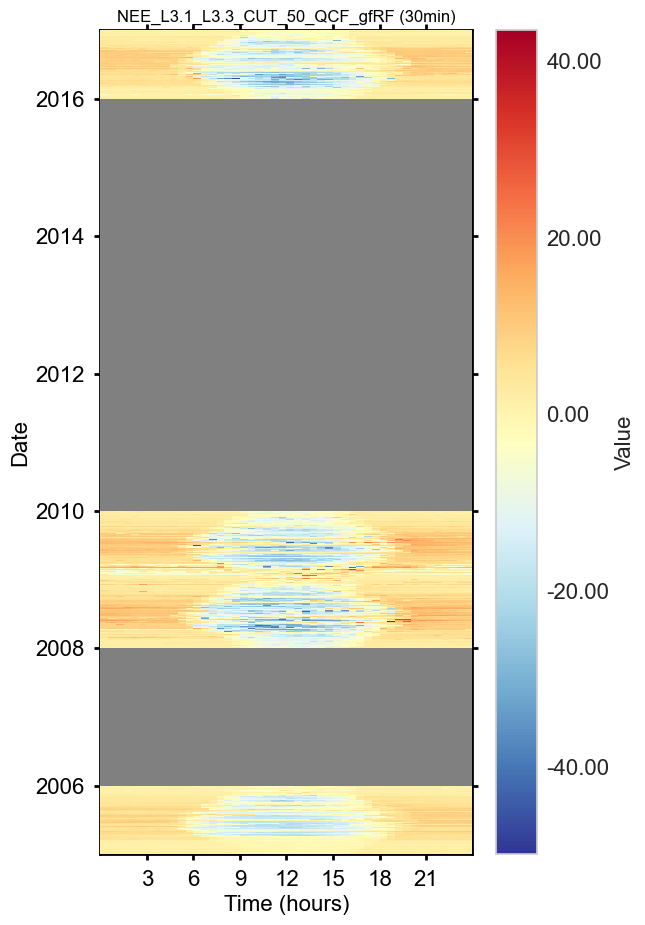

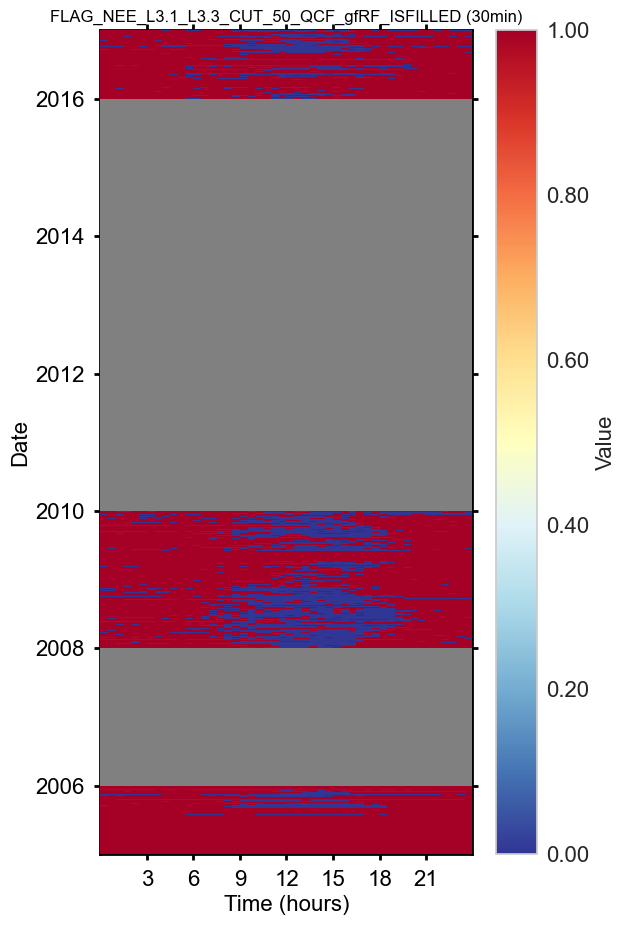

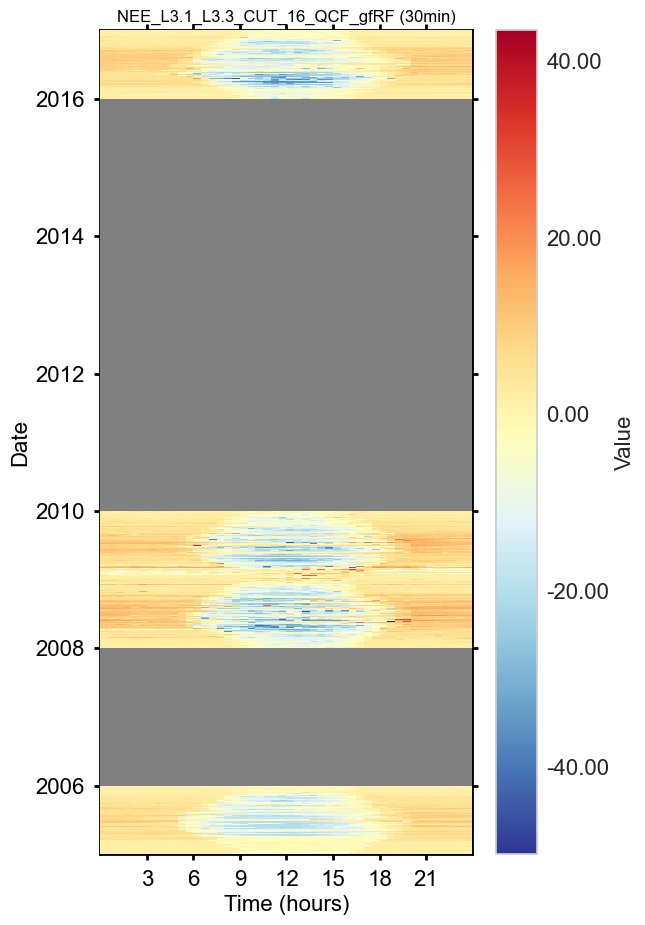

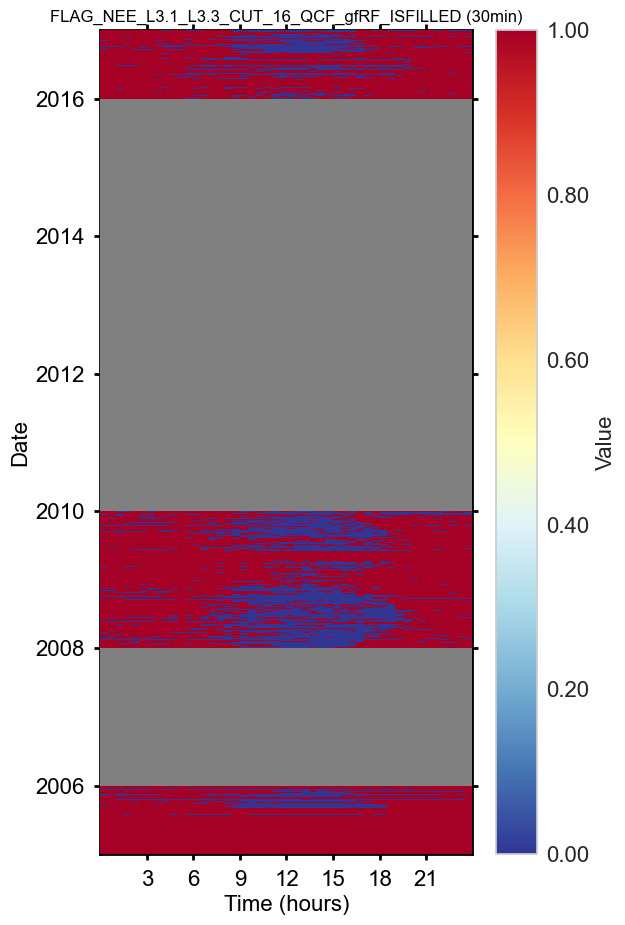

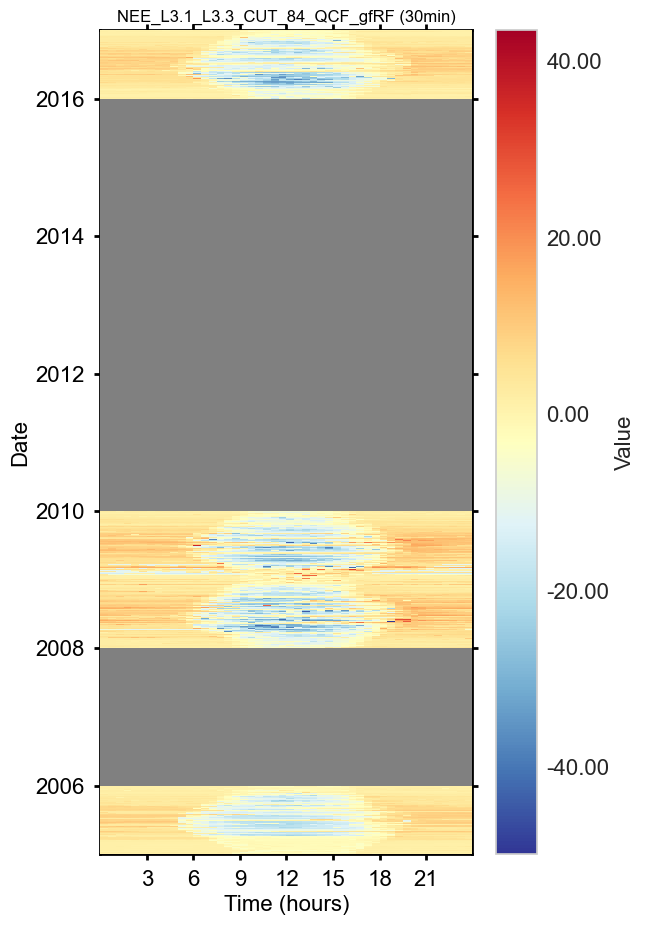

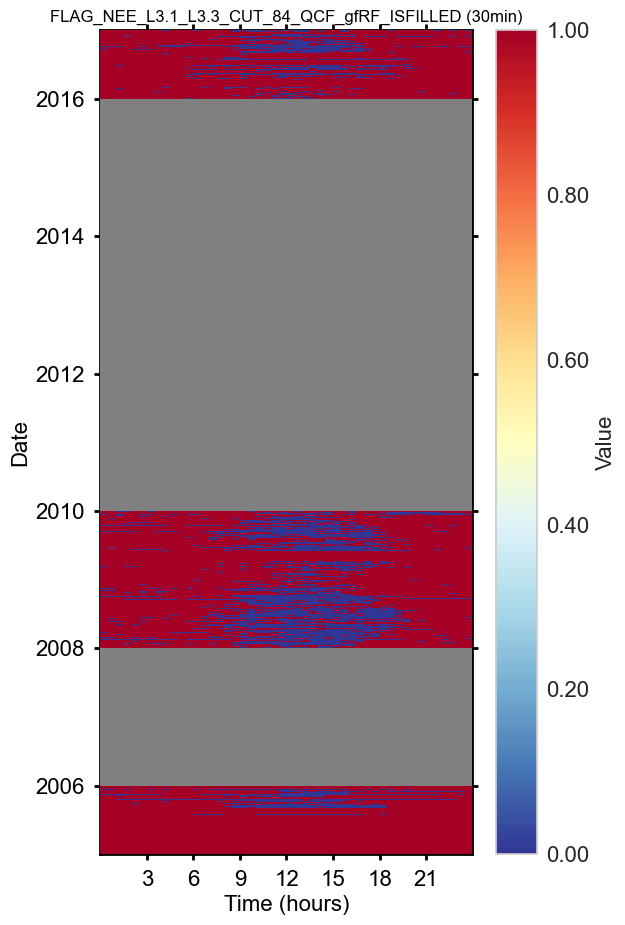

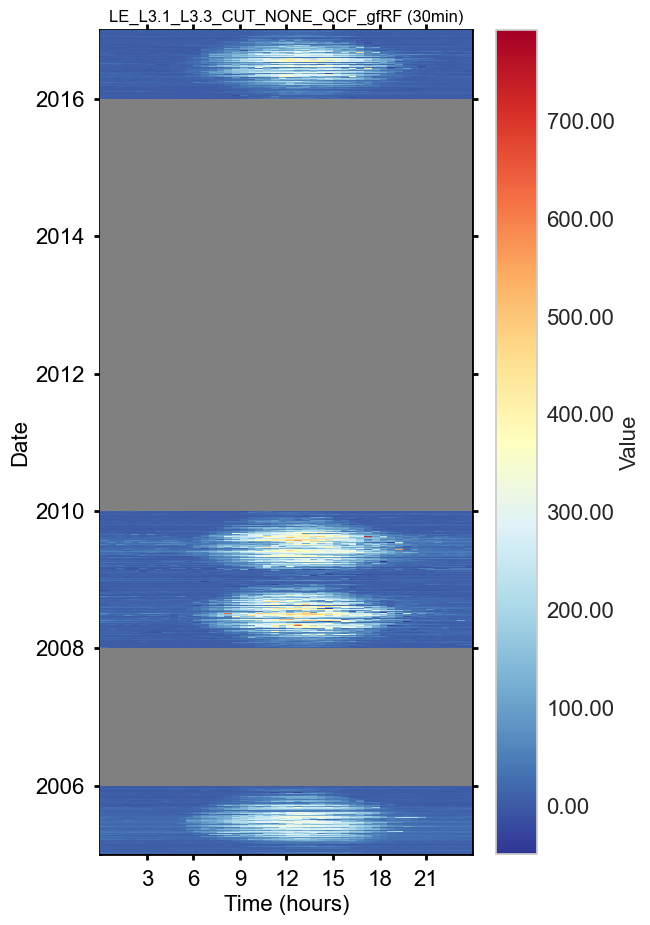

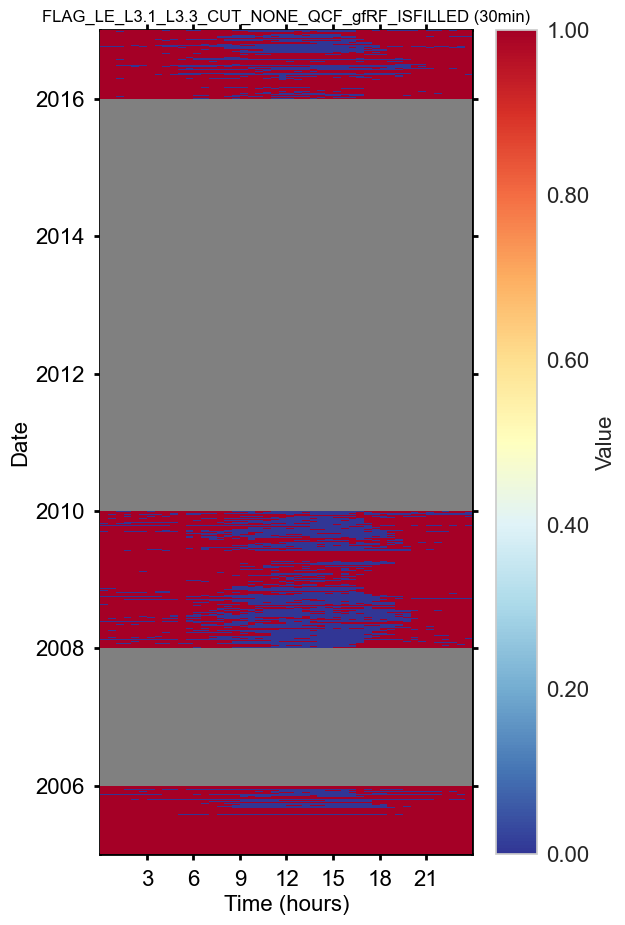

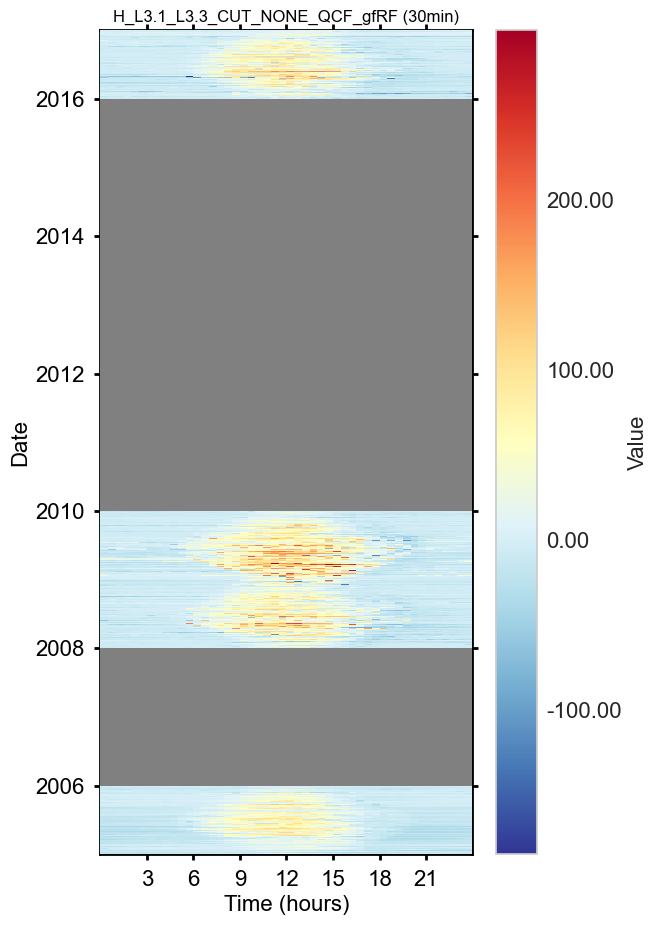

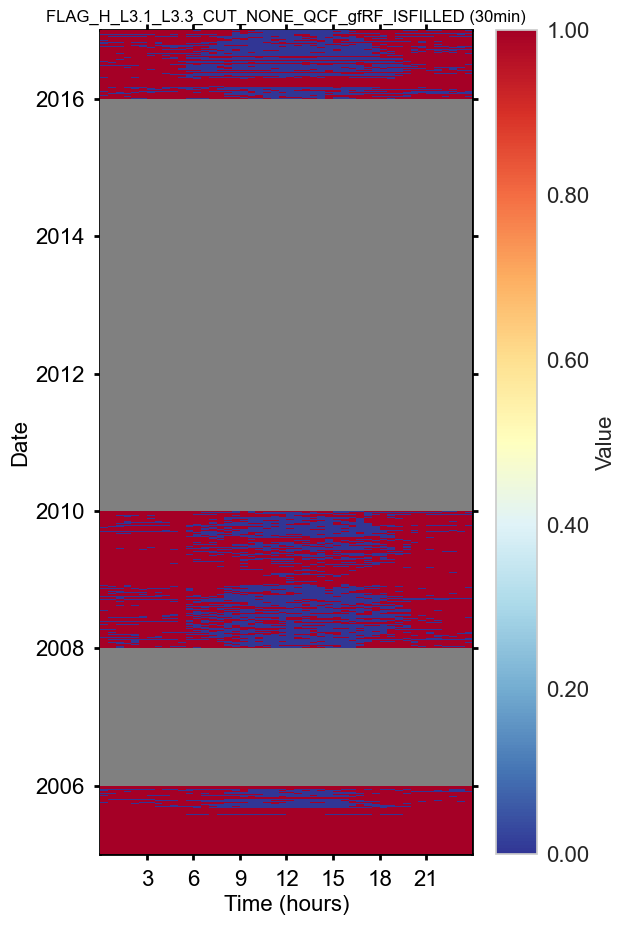

In [16]:
for c in collection_df.columns:
    HeatmapDateTime(series=collection_df[c]).plot()

In [17]:
# locs = (collection_df['FLAG_NEE_L3.1_L3.3_CUT_50_QCF_gfRF_ISFILLED'] == 1) & (collection_df['NEE_L3.1_L3.3_CUT_50_QCF_gfRF'] < 0)
# collection_df[locs].describe()